In [1]:
import pymc as pm, polars as pl
import matplotlib.pyplot as plt, numpy as np, xarray as xr
import arviz as az

In [32]:
LDS = pl.read_csv("../../Rethinking_2/End_of_chapter_problems/data/wikipedia_lds.csv")
divorce_data = pl.read_csv("../../Rethinking_2/Data/WaffleDivorce.csv", separator=";")

divorce_data = divorce_data.join(left_on="Location", right_on="State", other=LDS.select("State", "LDS")).select(
    "Divorce", "Marriage", "MedianAgeMarriage", "LDS"
).with_columns(pl.col("LDS").str.replace("%", "").cast(pl.Float32))


In [33]:
# standartization
divorce_data = divorce_data.with_columns((pl.all() - pl.all().mean())/pl.all().std())

In [39]:
divorce_data

Divorce,Marriage,MedianAgeMarriage,LDS
f64,f64,f64,f32
1.654205,0.022644,-0.60629,-0.264105
1.544364,1.549802,-0.686699,0.120308
0.610716,0.048974,-0.204241,0.26358
2.093569,1.655123,-1.410387,-0.233836
-0.927058,-0.266989,0.599857,-0.149084
…,…,…,…
-0.432773,0.101635,0.278218,-0.227782
0.171352,0.338608,-0.123831,0.041609
0.665636,0.54925,-0.847519,-0.244935


array([[<Axes: ylabel='Marriage'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='MedianAgeMarriage'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Divorce', ylabel='LDS'>,
        <Axes: xlabel='Marriage'>, <Axes: xlabel='MedianAgeMarriage'>]],
      dtype=object)

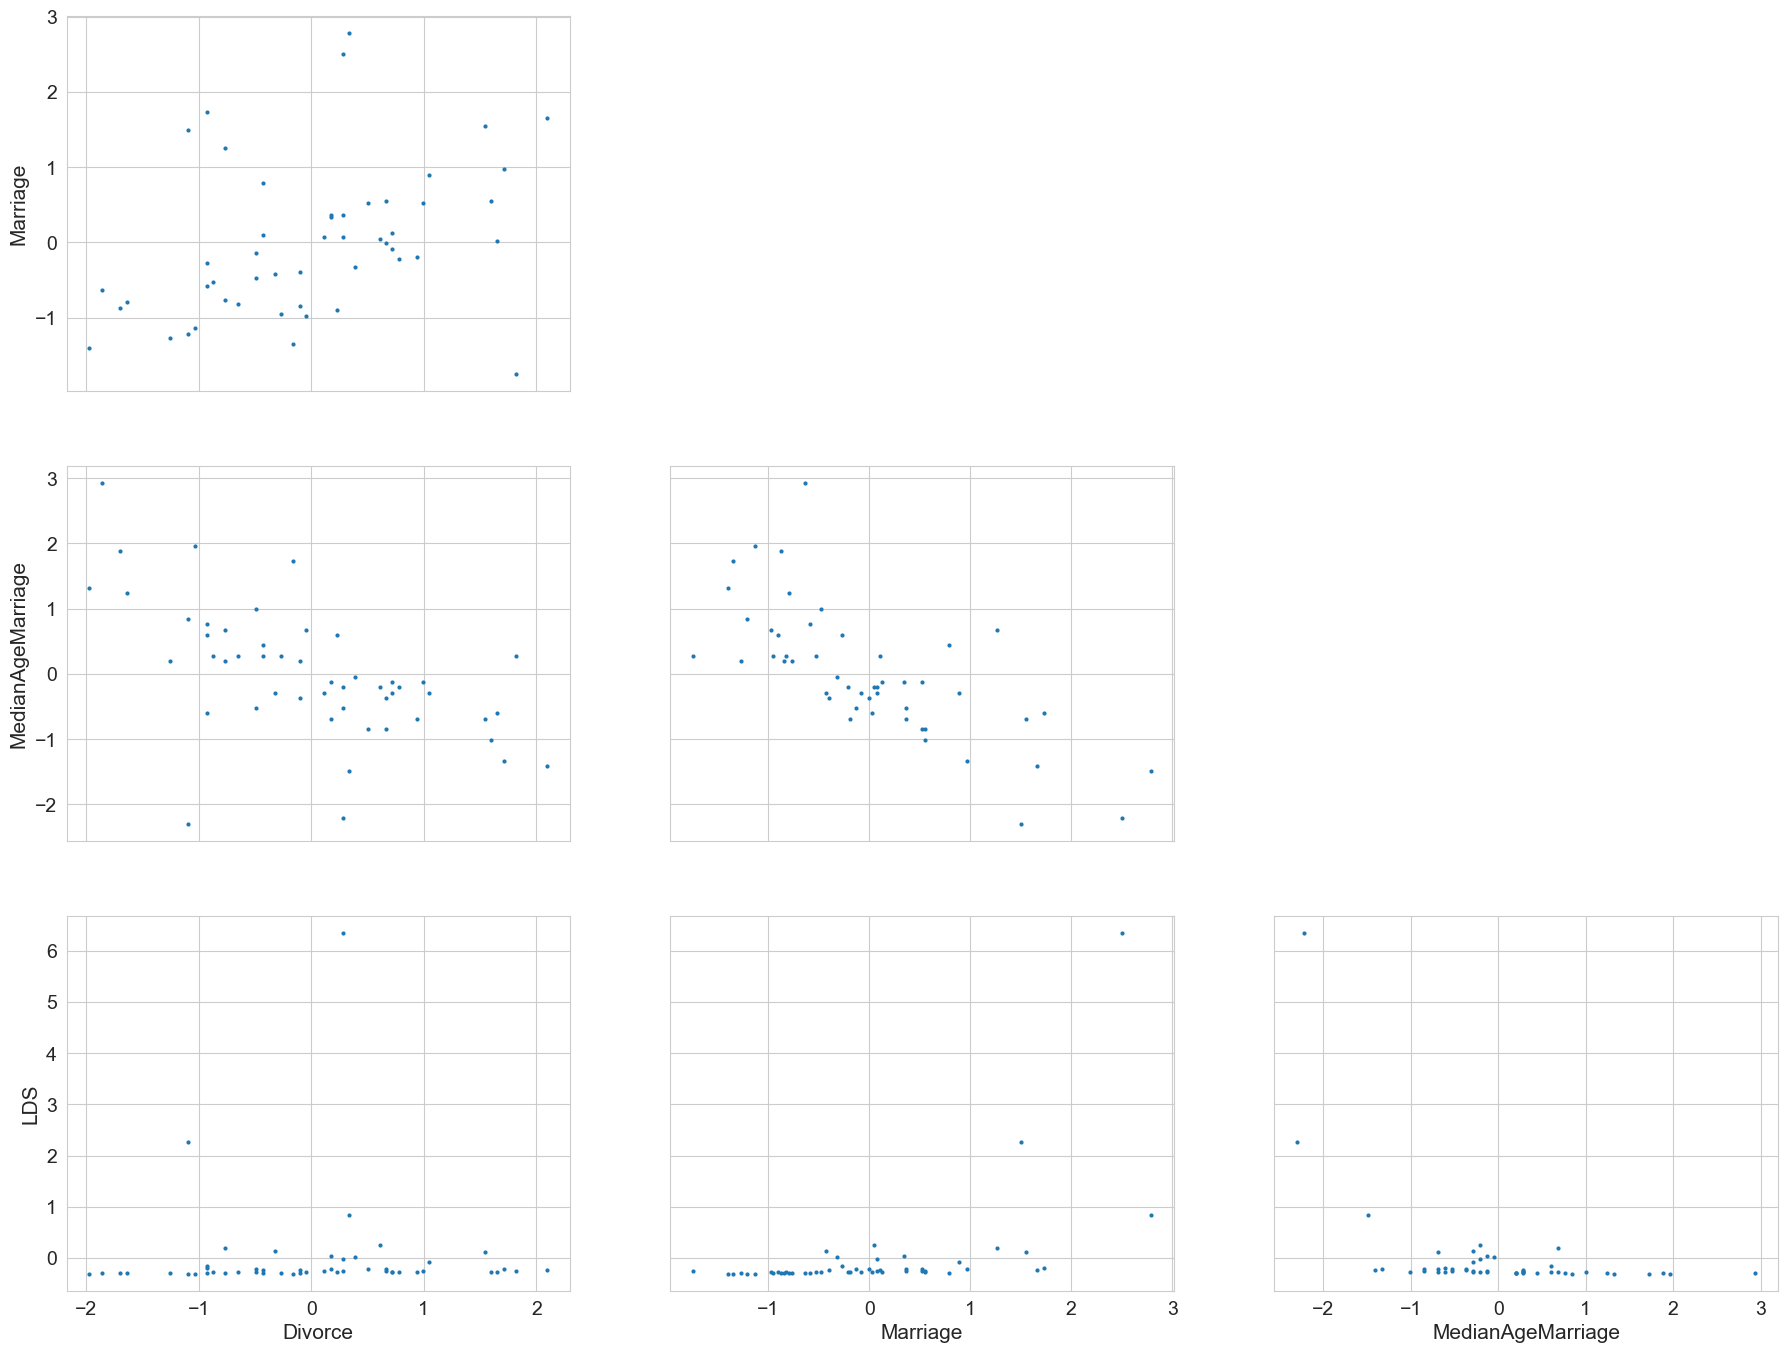

In [35]:
az.plot_pair(divorce_data.to_dict())

In [36]:
# model definition
with pm.Model() as basic_model:
    # priors
    alpha = pm.Normal('alpha', 0, 5)
    beta = pm.Normal('beta1', 0, 1)
    beta2 = pm.Normal('beta2', 0, 1)
    beta3 = pm.Normal('beta3', 0, 1)
    sigma = pm.Exponential('sigma', 2)

    mu = alpha + beta*divorce_data["Marriage"].to_numpy() + beta2*divorce_data["MedianAgeMarriage"].to_numpy() + beta3*divorce_data["LDS"].to_numpy()
    D = pm.Normal('divorce_rat', mu, sigma, observed=divorce_data["Divorce"].to_numpy())

    # check prior predictive
    idata = pm.sample_prior_predictive(draws=100)

Sampling: [alpha, beta1, beta2, beta3, divorce_rat, sigma]


In [37]:
with basic_model:
    idata_posterior = pm.sample(draws=1000)

idata_posterior

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

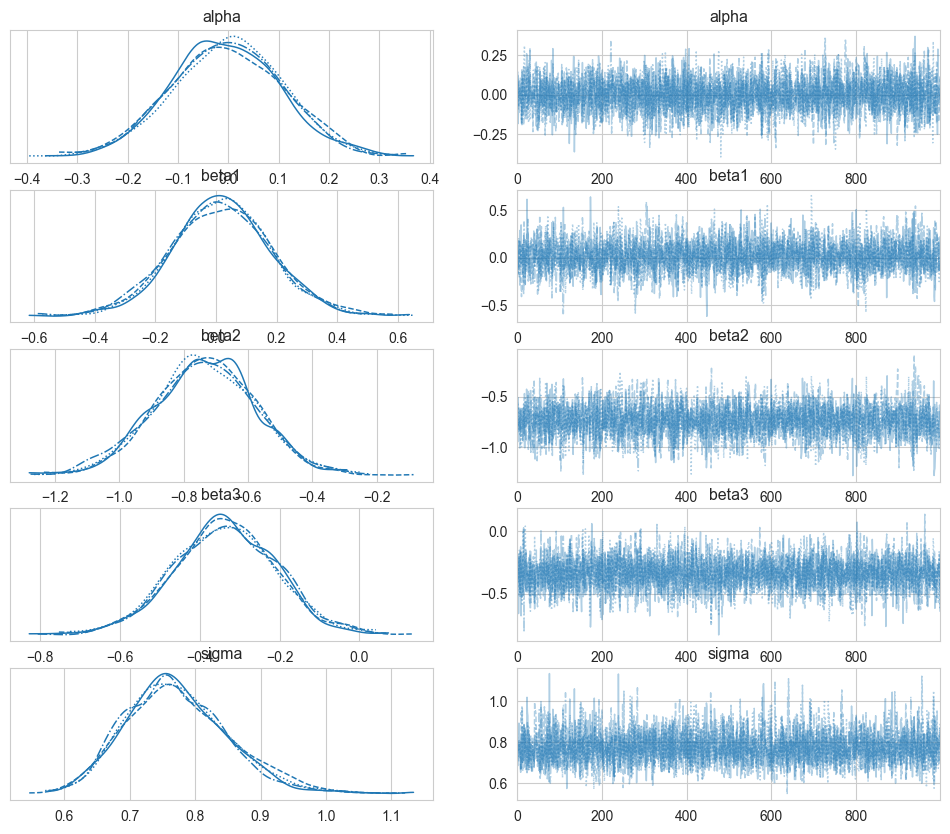

In [38]:
az.plot_trace(idata_posterior["posterior"])